In [0]:
!pip install xgboost seaborn --quiet

In [0]:
import numpy as np
import pandas as pd
import scipy
import io
#from google.colab import files
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold
import seaborn as sns

pd.options.mode.chained_assignment = None

#### Read train data

In [0]:
#can also import data using these URLs by replacing file path with URL in pd.read_csv
# df_url = "https://raw.githubusercontent.com/RishabhRJain/Building-permit-category-prediction-challenge/master/train_file.csv"
# testdf_url = "https://raw.githubusercontent.com/RishabhRJain/Building-permit-category-prediction-challenge/master/test_file.csv"
df = pd.read_csv('./train.csv', sep = ',')


In [5]:
df.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location,Category
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16T00:00:00,2018-01-16T00:00:00,NaN,2019-07-16T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.636732,-122.319828,"{'latitude': '47.63673222', 'human_address': '...",SINGLE FAMILY / DUPLEX
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13T00:00:00,2015-04-16T00:00:00,2016-11-15T00:00:00,2016-10-16T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.518298,-122.355555,"{'latitude': '47.51829831', 'human_address': '...",COMMERCIAL
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04T00:00:00,2014-09-04T00:00:00,2015-11-20T00:00:00,2016-03-04T00:00:00,Permit Closed,IA/INTERIOR ARCHITECTS,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.624025,-122.337567,"{'latitude': '47.62402492', 'human_address': '...",COMMERCIAL
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.595020,-122.328530,"{'latitude': '47.59502036', 'human_address': '...",COMMERCIAL
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02T00:00:00,2013-12-19T00:00:00,2015-05-14T00:00:00,2015-06-19T00:00:00,Permit Closed,SEATTLE PARKS DEPT,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.705686,-122.320134,"{'latitude': '47.70568601', 'human_address': '...",COMMERCIAL


In [6]:
print("Info about Data:")
print("Number of rows: ", df.shape[0])
print("Number of Columns: ", df.shape[1])
print("\nNumber of null values in each column:\n", df.isnull().sum())

Info about Data:
Number of rows:  33539
Number of Columns:  19

Number of null values in each column:
 Application/Permit Number              0
Permit Type                            0
Address                               19
Description                           10
Action Type                          779
Work Type                              0
Applicant Name                       135
Application Date                    6939
Issue Date                         10624
Final Date                         17851
Expiration Date                    10569
Status                              1574
Contractor                         27503
Permit and Complaint Status URL        0
Master Use Permit                  29041
Latitude                              21
Longitude                             21
Location                               8
Category                               0
dtype: int64


In [0]:
y_train = df['Category']
df = df.drop('Category' , axis = 1)

#### Read Test Data

In [0]:
test_df = pd.read_csv('./test.csv', sep = ',')

In [9]:
print("Info about Data:")
print("Number of rows: ", test_df.shape[0])
print("Number of Columns: ", test_df.shape[1])

Info about Data:
Number of rows:  22360
Number of Columns:  18


#### Merge train and test data set

In [10]:
train_test = pd.concat([df, test_df], join = 'inner')
train_test.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16T00:00:00,2018-01-16T00:00:00,NaN,2019-07-16T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.636732,-122.319828,"{'latitude': '47.63673222', 'human_address': '..."
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13T00:00:00,2015-04-16T00:00:00,2016-11-15T00:00:00,2016-10-16T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.518298,-122.355555,"{'latitude': '47.51829831', 'human_address': '..."
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04T00:00:00,2014-09-04T00:00:00,2015-11-20T00:00:00,2016-03-04T00:00:00,Permit Closed,IA/INTERIOR ARCHITECTS,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.624025,-122.337567,"{'latitude': '47.62402492', 'human_address': '..."
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.595020,-122.328530,"{'latitude': '47.59502036', 'human_address': '..."
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02T00:00:00,2013-12-19T00:00:00,2015-05-14T00:00:00,2015-06-19T00:00:00,Permit Closed,SEATTLE PARKS DEPT,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.705686,-122.320134,"{'latitude': '47.70568601', 'human_address': '..."


In [11]:
print("Info about Data:")
print("Number of rows: ", train_test.shape[0])
print("Number of Columns: ", train_test.shape[1])
print("\n Number of null values in both train and test data: \n", train_test.isnull().sum())

Info about Data:
Number of rows:  55899
Number of Columns:  18

 Number of null values in both train and test data: 
 Application/Permit Number              0
Permit Type                            0
Address                               35
Description                           21
Action Type                         1259
Work Type                              0
Applicant Name                       220
Application Date                   11436
Issue Date                         17565
Final Date                         29812
Expiration Date                    17484
Status                              2609
Contractor                         45748
Permit and Complaint Status URL        0
Master Use Permit                  48395
Latitude                              37
Longitude                             37
Location                              14
dtype: int64


## Data clean

#### Drop columns which we are sparse (Final Date), redundant (Location can be got through Latitude and Longitude features) or if you think they dont help in predicting Target category (Application Id)

In [0]:
del_columns = ['Master Use Permit', 'Permit and Complaint Status URL', 
                'Location', 'Issue Date', 'Final Date']
train_test.drop(del_columns, axis = 1, inplace = True)

#### check number of unique values and categories in categorical columns

In [13]:
train_test.nunique()

Application/Permit Number    55899
Permit Type                      3
Address                      33914
Description                  47926
Action Type                     16
Work Type                        2
Applicant Name               14639
Application Date              2557
Expiration Date               1700
Status                          12
Contractor                    2235
Latitude                     32719
Longitude                    38129
dtype: int64

#### we see that even Applicant's name is repeated since there are only 14k unique values from sample size of 55k. This means it is generally the contractors or the builders who will file an application. Hence Applicant names are repeated

In [14]:
binary_cols =  train_test.nunique()[train_test.nunique().values == 2].keys().tolist()

# Maximum categories are for Action type. Hence threshold for categorical columns has been kept at 20
categorical_cols = train_test.nunique()[train_test.nunique().values <= 20].keys().tolist()
categorical_cols = [col for col in categorical_cols if col not in binary_cols]

date_cols = ['Application Date',  'Expiration Date']

location_cols = ['Latitude', 'Longitude' ]

text_cols = ['Address', 'Description', 'Contractor' ]

print("Binary columns are: ", binary_cols)
print("Categorical columns are: ", categorical_cols)
print("Date columns are: ", date_cols)
print("Location columns are: ", location_cols)
print("Text columns are: ", text_cols)

Binary columns are:  ['Work Type']
Categorical columns are:  ['Permit Type', 'Action Type', 'Status']
Date columns are:  ['Application Date', 'Expiration Date']
Location columns are:  ['Latitude', 'Longitude']
Text columns are:  ['Address', 'Description', 'Contractor']


#### convert date_cols to Datetime

In [0]:
for col in date_cols:
  train_test[col] = pd.to_datetime(train_test[col])

#### Remove or replace NaN values

In [0]:
for col in categorical_cols + text_cols:
    train_test[col].fillna('NA', inplace = True)
   
for col in location_cols:
    train_test[col].fillna(train_test[col].mean(), inplace = True)

train_test['Applicant Name'].fillna('', inplace = True)

In [17]:
train_test.isnull().sum()

Application/Permit Number        0
Permit Type                      0
Address                          0
Description                      0
Action Type                      0
Work Type                        0
Applicant Name                   0
Application Date             11436
Expiration Date              17484
Status                           0
Contractor                       0
Latitude                         0
Longitude                        0
dtype: int64

In [18]:
for col in categorical_cols:
    print("\n{}: {} \n {}".format(col, train_test[col].nunique(), train_test[col].unique()))


Permit Type: 3 
 ['Construction' 'Demolition' 'Site Development']

Action Type: 17 
 ['ADD/ALT' 'DEMOLITION' 'ALTER' 'NEW' 'TREE/VEGETATION MAINT/RESTORE'
 'NO CONSTRUCTION' 'NA' 'TEMP' 'CURB CUT' 'GRADING'
 'SHORELINE EXEMPTION ONLY' 'SITE MONITORING ONLY' 'DECONSTRUCTION'
 'RELOCATION' 'FLOODPLAIN LICENSE ONLY' 'TREE PROTECTION EXEMPTION'
 'DRAINAGE APPROVAL']

Status: 13 
 ['Permit Issued' 'Permit Closed' 'Initial Information Collected'
 'Permit Finaled' 'AP Closed' 'CANCELLED' 'Application Accepted' 'NA'
 'Reviews Completed' 'Information Collected'
 'Cert of Occupancy Authorized' 'AP Finaled' 'Inspections Added']


#### Before one hot encoding, create a train copy to be used for visualisation 

In [0]:
df_copy = train_test[:len(y_train)]
df_copy['Category'] = y_train

#### one hot encode categorical and binary columns in train and test data

In [0]:
train_test = pd.get_dummies(train_test, columns = categorical_cols)

le_bin = LabelEncoder()
for col in binary_cols:
    train_test[col] = le_bin.fit_transform(train_test[col])

## Visualisation

In [21]:
df_copy.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Expiration Date,Status,Contractor,Latitude,Longitude,Category
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16,2019-07-16,Permit Issued,NA,47.636732,-122.319828,SINGLE FAMILY / DUPLEX
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13,2016-10-16,Permit Closed,NA,47.518298,-122.355555,COMMERCIAL
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04,2016-03-04,Permit Closed,IA/INTERIOR ARCHITECTS,47.624025,-122.337567,COMMERCIAL
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaT,NaT,Initial Information Collected,NA,47.595020,-122.328530,COMMERCIAL
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02,2015-06-19,Permit Closed,SEATTLE PARKS DEPT,47.705686,-122.320134,COMMERCIAL


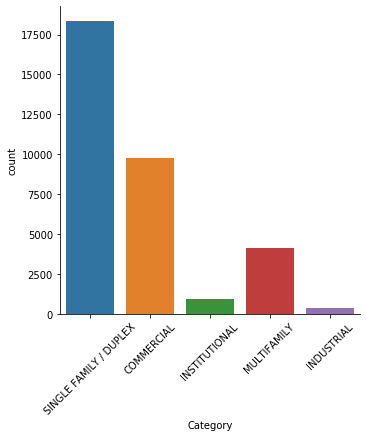

In [22]:
catplot = sns.catplot(x="Category", kind="count", data=df_copy)
catplot.set_xticklabels(rotation=45)
catplot.set_titles('Category' )
catplot.savefig('./category.png')

##### As we see above, we have an imbalanced Dataset

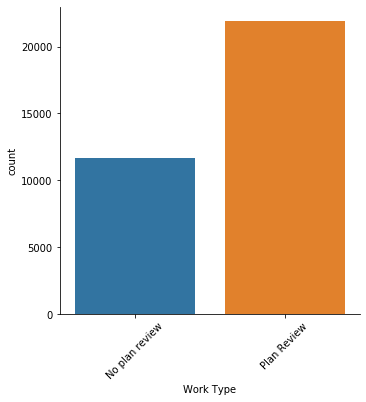

In [23]:
work_plot = sns.catplot(x="Work Type", kind="count", data=df_copy)
work_plot.set_xticklabels(rotation=45)
work_plot.set_titles('Work Type' )

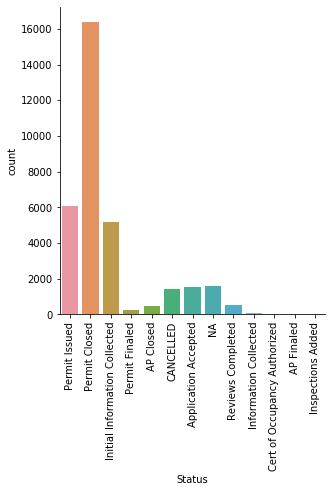

In [24]:
 status_plot = sns.catplot(x="Status", kind="count", data=df_copy)
status_plot.set_xticklabels(rotation=90)
status_plot.set_titles('Status' )

In [25]:
print("Top applicants for building permit: \n{}".format(df_copy['Applicant Name'].value_counts()[:5]))


Top applicants for building permit: 
WEBER, JULIAN             641
BIDDLE, DAVE              609
PATTERSON-O'HARE, JODI    472
PAROLINE, ANDY            307
NOVION, SHAUN             273
Name: Applicant Name, dtype: int64


In [26]:
values = df_copy['Applicant Name'].value_counts()[:5].values.tolist()
names = df_copy['Applicant Name'].value_counts()[:5].keys().tolist()
print("names: ", names)
print("values: ", values)
#plt.bar(keys, values)

names:  ['WEBER, JULIAN', 'BIDDLE, DAVE', "PATTERSON-O'HARE, JODI", 'PAROLINE, ANDY', 'NOVION, SHAUN']
values:  [641, 609, 472, 307, 273]


In [27]:
categories = df_copy['Category'].unique().tolist()
dictionary = {cat:[] for cat in categories}

for name in names:
    cats = df_copy[df_copy['Applicant Name'] == name]['Category'].value_counts().keys().tolist()
    cat_count = df_copy[df_copy['Applicant Name'] == name]['Category'].value_counts().values.tolist()
    
    not_found_categories = [category for category in categories if category not in cats]
    for cat in not_found_categories:
        dictionary[cat].append(0)
        
    for i,cat in enumerate(cats):
            dictionary[cat].append(cat_count[i])
        
print("Top 5 applicant names according to categories: \n", dictionary)

Top 5 applicant names according to categories: 
 {'SINGLE FAMILY / DUPLEX': [394, 458, 11, 21, 207], 'COMMERCIAL': [19, 25, 288, 266, 6], 'INSTITUTIONAL': [2, 0, 62, 1, 0], 'MULTIFAMILY': [226, 126, 111, 18, 59], 'INDUSTRIAL': [0, 0, 0, 1, 1]}


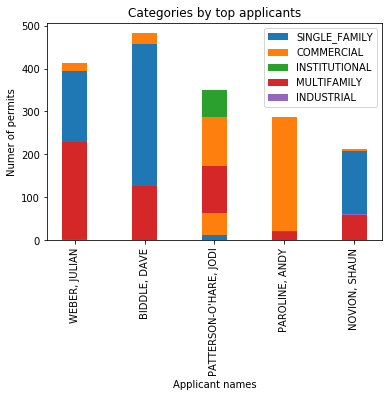

In [28]:
SINGLE_FAMILY = dictionary['SINGLE FAMILY / DUPLEX']
COMMERCIAL = dictionary['COMMERCIAL']
INSTITUTIONAL = dictionary['INSTITUTIONAL']
MULTIFAMILY = dictionary['MULTIFAMILY']
INDUSTRIAL = dictionary['INDUSTRIAL']

ind = np.arange(5)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, SINGLE_FAMILY, width )

p2 = plt.bar(ind, COMMERCIAL, width,
             bottom=SINGLE_FAMILY)

p3 = plt.bar(ind, INSTITUTIONAL, width,
             bottom=COMMERCIAL)

p4 = plt.bar(ind, MULTIFAMILY, width,
             bottom=INSTITUTIONAL)

p5 = plt.bar(ind, INDUSTRIAL, width,
             bottom=MULTIFAMILY)

plt.title('Categories by top applicants')
plt.xlabel('Applicant names')
plt.ylabel('Numer of permits')
plt.xticks(ind, names, rotation = 'vertical')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('SINGLE_FAMILY', 'COMMERCIAL', 'INSTITUTIONAL', 'MULTIFAMILY', 'INDUSTRIAL'))

plt.show()

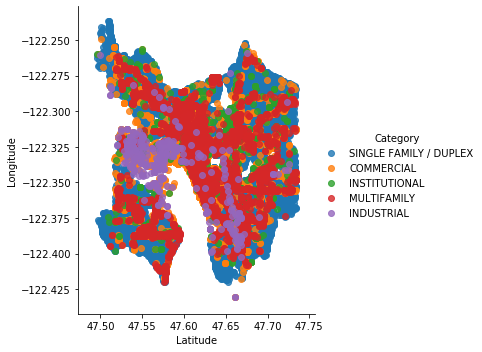

In [29]:
sns.lmplot( x="Latitude", y="Longitude", data=df_copy, fit_reg=False, hue='Category', legend=True)

## Copy clean train data back from train_test dataframe

In [0]:
df = train_test[:len(y_train)]
df['Category'] = y_train

#### create a date dataframe to understand the time difference between expiration and application date based on Category

In [0]:
#drop rows in which Application or Expiration Date is empty
date_df = df.dropna(subset=date_cols, how='any')

In [0]:
date_df['total period'] = (date_df['Expiration Date'] - date_df['Application Date']).dt.days

#### We see that different categories have time periods for Expiration Date with Multi family Categories having longest duration

In [33]:
diff = date_df.groupby(['Category'])['total period'].mean()
diff

Category
COMMERCIAL                649.047861
INDUSTRIAL                718.448980
INSTITUTIONAL             695.557070
MULTIFAMILY               753.878155
SINGLE FAMILY / DUPLEX    655.072607
Name: total period, dtype: float64

#### We will use the above data for imputing NaN date values in train data based on categories

In [34]:
# Mean time  for Total period across all Categories. We use this to append NaN values in test data
diff.mean()

694.4009342795456

#### Finding time difference in days for train data

#### Fill NaN values in total period column with mean value based on Category

In [0]:
df['total period'] = (df['Expiration Date'] - df['Application Date']).dt.days

In [0]:
df['total period'] = df.apply(
    lambda row: diff[row['Category']] if np.isnan(row['total period']) else df['total period'], axis=1)

In [0]:
df.drop(date_cols, axis = 1, inplace = True)

#### use label encoding for Target variable

In [38]:
le = LabelEncoder()
target = le.fit_transform(df['Category'])
df.drop('Category', axis = 1, inplace = True)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'COMMERCIAL': 0, 'INDUSTRIAL': 1, 'INSTITUTIONAL': 2, 'MULTIFAMILY': 3, 'SINGLE FAMILY / DUPLEX': 4}


In [0]:
df['Latitude'].fillna((df['Latitude'].mean()), inplace=True)
df['Longitude'].fillna((df['Longitude'].mean()), inplace=True)

In [40]:
 df.head()

,Application/Permit Number,Address,Description,Work Type,Applicant Name,Contractor,Latitude,Longitude,Permit Type_Construction,Permit Type_Demolition,Permit Type_Site Development,Action Type_ADD/ALT,Action Type_ALTER,Action Type_CURB CUT,Action Type_DECONSTRUCTION,Action Type_DEMOLITION,Action Type_DRAINAGE APPROVAL,Action Type_FLOODPLAIN LICENSE ONLY,Action Type_GRADING,Action Type_NA,Action Type_NEW,Action Type_NO CONSTRUCTION,Action Type_RELOCATION,Action Type_SHORELINE EXEMPTION ONLY,Action Type_SITE MONITORING ONLY,Action Type_TEMP,Action Type_TREE PROTECTION EXEMPTION,Action Type_TREE/VEGETATION MAINT/RESTORE,Status_AP Closed,Status_AP Finaled,Status_Application Accepted,Status_CANCELLED,Status_Cert of Occupancy Authorized,Status_Information Collected,Status_Initial Information Collected,Status_Inspections Added,Status_NA,Status_Permit Closed,Status_Permit Finaled,Status_Permit Issued,Status_Reviews Completed,total period
0,6640280,1924 10TH AVE E,"Alterations to single family residence, (porti...",0,"ZHANG, JERRY",NA,47.636732,-122.319828,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,546.000000
1,6452959,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,1,"MARTIN, TERRY",NA,47.518298,-122.355555,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000
2,6435127,535 TERRY AVE N,Construct interior alterations to existing off...,0,"ALLEXSAHT, REBECCA",IA/INTERIOR ARCHITECTS,47.624025,-122.337567,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000
3,6620870,830 4TH AVE S,need to remove a fire escape that is not part ...,1,"JUNK, FRANK",NA,47.595020,-122.328530,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,649.047861
4,6363778,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",1,"DANIEL, MARK",SEATTLE PARKS DEPT,47.705686,-122.320134,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000


### Encoding Address column into a vector

In [0]:
#To convert some float values in Address column to string
df['Address'] = df['Address'].astype(str)

In [0]:
def modify_address(row):
  '''
  Takes complete address and returns only street name without spaces. 
  Modified address can be encoded and used to predict Category
  '''
  addr = row.split(" ", 1)
  if len(addr) > 1:
    addr = addr[1].replace(' ', '')
  else:
    addr = addr[0].replace(' ', '')
  return addr

##For example try this:
#(df['Address'][0].split(" ", 1)[1]).replace(' ', '')

df['Address'] = df['Address'].apply(modify_address)

In [43]:
addr_vectorizer = CountVectorizer(min_df = 2) 
addr_vector = addr_vectorizer.fit_transform(df['Address'].tolist())  
addr_vector

<33539x1498 sparse matrix of type '<class 'numpy.int64'>'
	with 33305 stored elements in Compressed Sparse Row format>

### Encoding Description column into a vector

#### Using Count Vectorizer for Description column

In [44]:
desc_vectorizer = CountVectorizer(min_df=5 , stop_words='english') 
desc_vector = desc_vectorizer.fit_transform(df['Description'].tolist())  
desc_vector

<33539x2631 sparse matrix of type '<class 'numpy.int64'>'
	with 379151 stored elements in Compressed Sparse Row format>

### Encoding Contractor into a vector

#### Using Count Vectorizer for Contractor column

In [45]:
contract_vectorizer = CountVectorizer(min_df = 2) 
contract_vector = contract_vectorizer.fit_transform(df['Contractor'].tolist())  
contract_vector

<33539x1118 sparse matrix of type '<class 'numpy.int64'>'
	with 46939 stored elements in Compressed Sparse Row format>

#### vectorizer for applicant name

In [46]:
name_vectorizer = CountVectorizer(min_df=2)
name_vector = name_vectorizer.fit_transform(df['Applicant Name'].tolist())
name_vector

<33539x4343 sparse matrix of type '<class 'numpy.int64'>'
	with 63949 stored elements in Compressed Sparse Row format>

In [47]:
vectors = scipy.sparse.hstack((addr_vector, desc_vector, contract_vector, name_vector))
vectors

<33539x9590 sparse matrix of type '<class 'numpy.int64'>'
	with 523344 stored elements in COOrdinate format>

### Seperate features and Target

In [0]:
y = target
df.drop([ 'Application/Permit Number', 'Address', 'Description',  'Contractor', 'Applicant Name' ], axis = 1, inplace = True)

In [62]:
print("Shape of input features: ", df.shape)
df.head()

Shape of input features:  (33539, 37)


,Work Type,Latitude,Longitude,Permit Type_Construction,Permit Type_Demolition,Permit Type_Site Development,Action Type_ADD/ALT,Action Type_ALTER,Action Type_CURB CUT,Action Type_DECONSTRUCTION,Action Type_DEMOLITION,Action Type_DRAINAGE APPROVAL,Action Type_FLOODPLAIN LICENSE ONLY,Action Type_GRADING,Action Type_NA,Action Type_NEW,Action Type_NO CONSTRUCTION,Action Type_RELOCATION,Action Type_SHORELINE EXEMPTION ONLY,Action Type_SITE MONITORING ONLY,Action Type_TEMP,Action Type_TREE PROTECTION EXEMPTION,Action Type_TREE/VEGETATION MAINT/RESTORE,Status_AP Closed,Status_AP Finaled,Status_Application Accepted,Status_CANCELLED,Status_Cert of Occupancy Authorized,Status_Information Collected,Status_Initial Information Collected,Status_Inspections Added,Status_NA,Status_Permit Closed,Status_Permit Finaled,Status_Permit Issued,Status_Reviews Completed,total period
0,0,47.636732,-122.319828,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,546.000000
1,1,47.518298,-122.355555,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000
2,0,47.624025,-122.337567,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000
3,1,47.595020,-122.328530,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,649.047861
4,1,47.705686,-122.320134,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000


#### Model building approach: stacking text vectors, numerical and categorical features

In [50]:
X = scipy.sparse.hstack((vectors, df))
print(type(X))
X.shape

<class 'scipy.sparse.coo.coo_matrix'>


(33539, 9627)

#### split train data into train and validate

In [0]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.1, random_state = 10, stratify = y)

In [52]:
X_train.shape

(30185, 9627)

In [0]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [54]:

params = [{'C': [0.01, 0.1, 1, 2], 'penalty': ['l1', 'l2']}]

grid_search = GridSearchCV(LogisticRegression(), param_grid=params, cv = 5)
grid_search.fit(X, y)
print("Best params: {}".format(grid_search.best_params_))
print("Best cross validation score: {}".format(grid_search.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best params: {'C': 1, 'penalty': 'l2'}
Best cross validation score: 0.921792540028027


#### Using Random Forest classifier

In [0]:
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators': [ 500, 600], 'max_depth': [ 15, 20]}]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv = 5)
grid_search.fit(df, target)
print("Best params: {}".format(grid_search.best_params_))
print("Best cross validation score: {}".format(grid_search.best_score_))

Best params: {'max_depth': 20, 'n_estimators': 500}
Best cross validation score: 0.875696949819613


In [0]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

In [66]:
np.unique(y, axis = 0)

array([0, 1, 2, 3, 4])

#### Since its an imbalanced dataset, we will assign weights to classes based on their occurence. Least occuring class gets more weight and vice versa. This lets the model focus on less frequentlu occuring classes.

In [71]:
largest_class_weight_coef = max(df_copy['Category'].value_counts().values)/df.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
weight[:5]

[0.6860227272727273,
 0.3657014780712382,
 0.3657014780712382,
 0.6860227272727273,
 0.3657014780712382]

In [122]:
xg = XGBClassifier(n_estimators=1000, weights = weight, max_depth=20)
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=...
                       0.3657014780712382, 0.6860227272727273,
                       0.3657014780712382, 0.6860227272727273,
                       0.3657014780712382, 0.3657014780712382,
                       0.3657014780712382, 0.3657014780712382,
                       0.3657014780712382, 0.3657014780712382,
                       1.635157096424702, 0.3657014780712382,
                       0.6860227272727273, 0.6860227272727273,
                       0.3657014780712382, 0.3657014780712382,
                       0.3657014780712

In [123]:
xg.score(X_validate, y_validate)

0.9478234943351223

### Evaluation Metrics
#### Since it is an imbalanced Data Set, we can evaluate performance by computing precision, recall and F1-score

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score, precision_recall_curve
%matplotlib inline

In [76]:
predictions = xg.predict(X_validate)
conf_matrix = confusion_matrix(y_validate,predictions)
print(conf_matrix)

[[ 926    4    9   17   22]
 [  13   26    0    0    0]
 [  16    0   73    1    3]
 [  20    0    0  337   53]
 [   7    0    1   27 1799]]


In [77]:
print(classification_report(y_validate, predictions, target_names = list(le_name_mapping.keys())))

                        precision    recall  f1-score   support

            COMMERCIAL       0.94      0.95      0.94       978
            INDUSTRIAL       0.87      0.67      0.75        39
         INSTITUTIONAL       0.88      0.78      0.83        93
           MULTIFAMILY       0.88      0.82      0.85       410
SINGLE FAMILY / DUPLEX       0.96      0.98      0.97      1834

              accuracy                           0.94      3354
             macro avg       0.91      0.84      0.87      3354
          weighted avg       0.94      0.94      0.94      3354



## Predict for Test Data

In [0]:
#splitting test data from cleaned train_test dataframe
test_df = train_test[df.shape[0]:]

In [0]:
test_df['Latitude'].fillna((test_df['Latitude'].mean()), inplace=True)
test_df['Longitude'].fillna((test_df['Longitude'].mean()), inplace=True)

#### Encode the test Address data into vector using previously trained Address vectorizer

In [0]:
test_df['Address'] = test_df['Address'].astype(str)
test_df['Address'] = test_df['Address'].apply(modify_address)

In [95]:
test_addr_vector = addr_vectorizer.transform(test_df['Address'].tolist())  
test_addr_vector.shape

(22360, 1498)

#### encode test Description data using previously trained Description vectorizer

In [96]:
test_desc_vector = desc_vectorizer.transform(test_df['Description'].tolist())  
test_desc_vector.shape

(22360, 2631)

#### encode test Contractor data using previously trained Contractor vectorizer

In [97]:
test_contract_vector = contract_vectorizer.transform(test_df['Contractor'].tolist())  
test_contract_vector.shape

(22360, 1118)

#### Encode Applicant name data

In [98]:
test_name_vector = name_vectorizer.transform(test_df['Applicant Name'].tolist())
test_name_vector.shape

(22360, 4343)

#### Stacking all vectors. Remember to keep the vectors in the same order used while creating training data

In [106]:
test_vectors = scipy.sparse.hstack((test_addr_vector, test_desc_vector, test_contract_vector, test_name_vector))
test_vectors

<22360x9590 sparse matrix of type '<class 'numpy.int64'>'
	with 344792 stored elements in COOrdinate format>

In [0]:
test_application_number = test_df['Application/Permit Number']
test_df.drop([ 'Application/Permit Number', 'Address', 'Description',  'Contractor', 'Applicant Name' ], axis = 1, inplace = True)

In [0]:
test_df['total period'] = (test_df['Expiration Date'] - test_df['Application Date']).dt.days
test_df['total period'].fillna(diff.mean(), inplace = True) 
test_df = test_df.drop(['Expiration Date','Application Date'] , axis = 1)


In [102]:
print(test_df.shape)
test_df.head()

(22360, 37)


,Work Type,Latitude,Longitude,Permit Type_Construction,Permit Type_Demolition,Permit Type_Site Development,Action Type_ADD/ALT,Action Type_ALTER,Action Type_CURB CUT,Action Type_DECONSTRUCTION,Action Type_DEMOLITION,Action Type_DRAINAGE APPROVAL,Action Type_FLOODPLAIN LICENSE ONLY,Action Type_GRADING,Action Type_NA,Action Type_NEW,Action Type_NO CONSTRUCTION,Action Type_RELOCATION,Action Type_SHORELINE EXEMPTION ONLY,Action Type_SITE MONITORING ONLY,Action Type_TEMP,Action Type_TREE PROTECTION EXEMPTION,Action Type_TREE/VEGETATION MAINT/RESTORE,Status_AP Closed,Status_AP Finaled,Status_Application Accepted,Status_CANCELLED,Status_Cert of Occupancy Authorized,Status_Information Collected,Status_Initial Information Collected,Status_Inspections Added,Status_NA,Status_Permit Closed,Status_Permit Finaled,Status_Permit Issued,Status_Reviews Completed,total period
0,0,47.690123,-122.379795,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,549.000000
1,0,47.540111,-122.290535,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,547.000000
2,0,47.540470,-122.281410,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,694.400934
3,1,47.654986,-122.327467,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,795.000000
4,0,47.666714,-122.383900,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,549.000000


In [107]:
X_test = scipy.sparse.hstack((test_vectors, test_df))
X_test.shape

(22360, 9627)

### predict Categories for Test Data

#### We do below step to avoid train and test feature order mismatch

In [0]:
test_df  = test_df[df.columns]

#### predict output categories (These are encoded values)

In [0]:
test_category = xg.predict(X_test)

#### Decode the above output to get Categories

In [0]:
test_category = le.inverse_transform(test_category)

#### create submission Dataframe and save

In [0]:
submission = pd.DataFrame({'Application/Permit Number': test_application_number, 'Category': test_category})

In [111]:
submission.shape

(22360, 2)

In [112]:
submission.head()

,Application/Permit Number,Category
0,6425384,SINGLE FAMILY / DUPLEX
1,6496502,SINGLE FAMILY / DUPLEX
2,6622347,INSTITUTIONAL
3,6565685,MULTIFAMILY
4,6487370,COMMERCIAL


In [0]:
submission.to_csv('./submission_modified.csv', sep = ',', index = False) 